In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm

import numpy as np
import random
import torch

import pmdarima as pm
from pmdarima import StepwiseContext
from pmdarima.model_selection import train_test_split

np.random.seed(0)
random.seed(0)

from metrics import calc_tdi_tdm, squared_error, absolute_error
from utilities import Evaluation
from datasets import get_dataset

In [3]:
def plot_result(train, test, forecast, model):
    x = np.arange(train.shape[0] + test.shape[0])
    l = len(train)
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 2.5))
    axs[0].plot(x[:l], train, c='blue')
    axs[0].plot(x[l:], test, c='red')
    axs[0].plot(x[l:], forecast, c='green')
    axs[0].set_title(f"Series {i}. Best fit: SARIMA{model.to_dict()['order']}{model.to_dict()['seasonal_order']}")
    
    axs[1].plot(x[l:], squared_error(test, forecast))
    axs[1].set_title(f"Squared errors")
    
    axs[2].plot(x[l:], absolute_error(test, forecast))
    axs[2].set_title(f"Absolute errors")
    plt.tight_layout()
    plt.show()

# TEST

In [4]:
archive=''
ds_name='Traffic'
in_size=24*3
out_size=24*3
arima_window=200
seasonal=True
m=24
test_size=500

batch_size = 10
results = []

train, test = get_dataset(archive, ds_name, in_size, out_size, test_size)
train_dl = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

In [5]:
train = train.series.squeeze().numpy()
test = test.series.squeeze().numpy()

print(train[-arima_window:].shape)
print(test.shape)

(200,)
(500,)


In [15]:
drop_last = len(test) % 11

In [21]:
len(test[:1])

1

In [8]:
len(test[:-drop_last])

0

In [20]:
MAX_ITER = 50

if seasonal:
    model = pm.auto_arima(train[-arima_window:],
                          start_p=1, start_q=1, max_p=5, max_q=5,
                          seasonal=True, m=m, max_P=5, max_Q=5,
                          trace=False,
                          suppress_warnings=True,
                          error_action='ignore',
                          stepwise=True,
                          maxiter=MAX_ITER)

else:
    model = pm.auto_arima(train[-arima_window:],
                          start_p=1, start_q=1, max_p=5, max_q=5,
                          seasonal=False,
                          trace=False,
                          suppress_warnings=True,
                          error_action='ignore',
                          stepwise=True,
                          maxiter=MAX_ITER)

In [21]:
# Get multi-step forecasts
x_test, y_test, yhat_test = [], [], []
x_history = []

# Update model on first input size sample
x = test[0:in_size]
y = test[in_size:in_size+out_size]

In [22]:
model.update(x)
yhat = model.predict(n_periods=out_size)  # Predict n steps into the future

x_test.append(x)
y_test.append(y)
yhat_test.append(yhat)

x_history.extend(x)

In [23]:
# Iterate from the first window, updating with the next step
for i in tqdm(range(1, len(test) - in_size - out_size), unit="step", desc=f"Generating ARIMA k-step forecasts"):
    x = test[i:i+in_size]
    y = test[i+in_size:i+in_size+out_size]

    model.update(x[-1])  # Update with LAST value as stepsize is 1 and the model retains previous values
    yhat = model.predict(n_periods=out_size)

    x_test.append(x)
    y_test.append(y)
    yhat_test.append(yhat)
    x_history.append(x[-1])

Generating ARIMA k-step forecasts: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:08<00:00,  3.47step/s]


In [24]:
x_test, y_test, yhat_test = np.array(x_test), np.array(y_test), np.array(yhat_test)

In [25]:
x_test.shape

(32, 72)

In [18]:
results.append(Evaluation(x_test, y_test, yhat_test, ds_name, "SARIMA"))

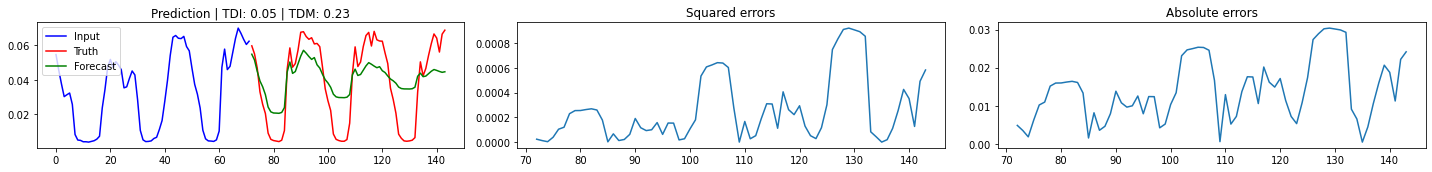

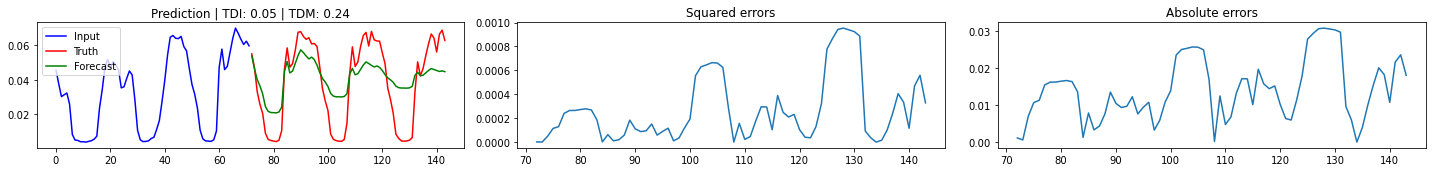

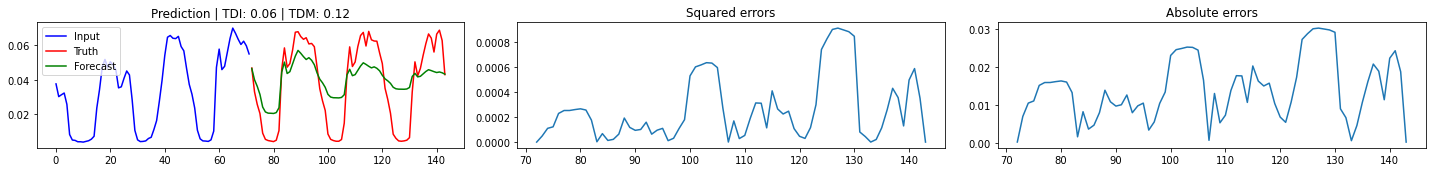

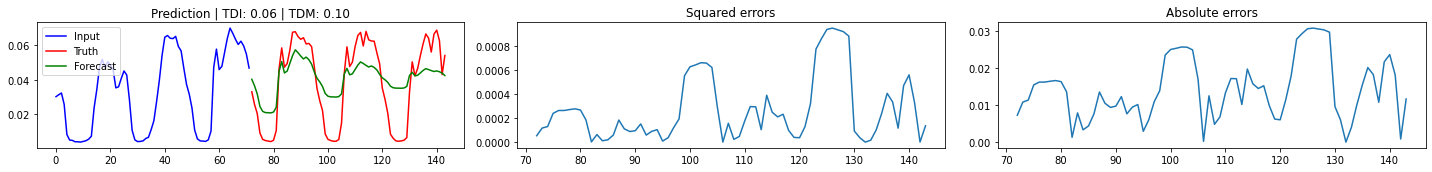

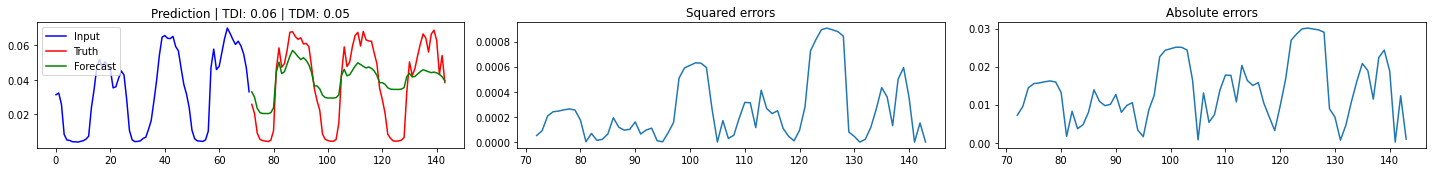

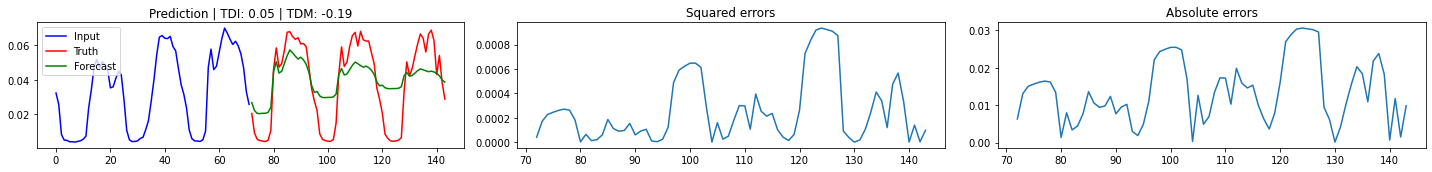

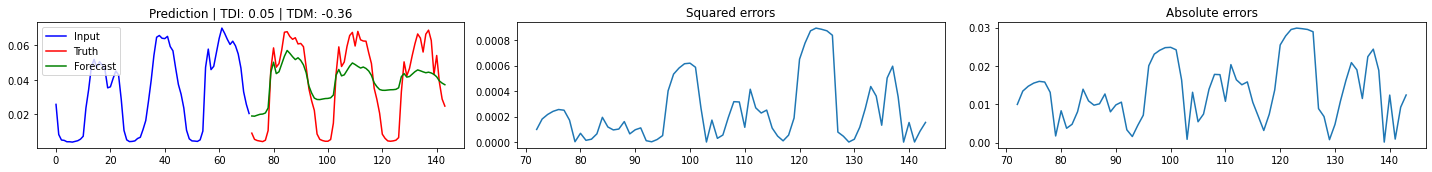

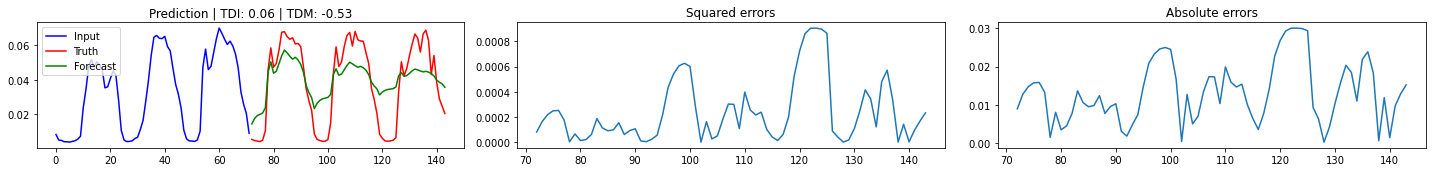

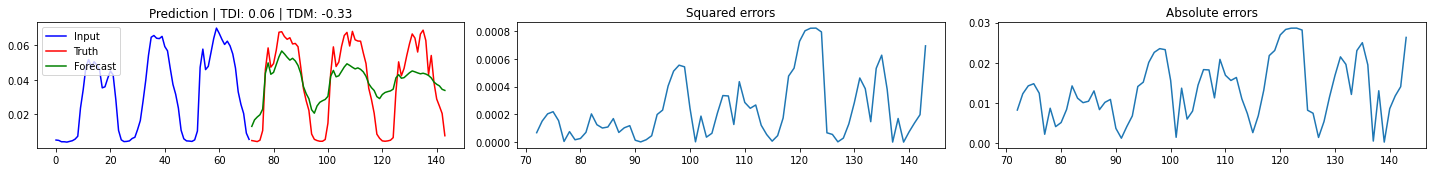

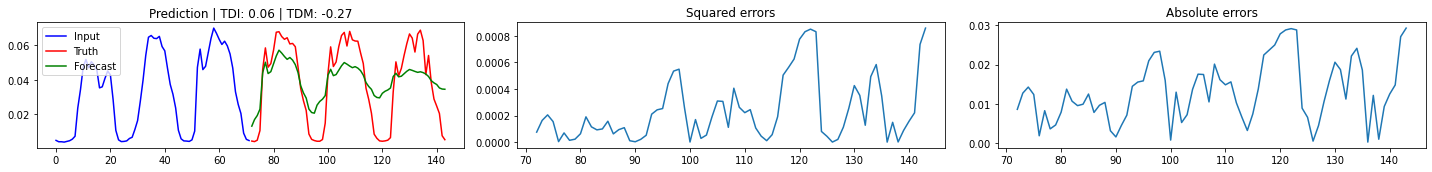

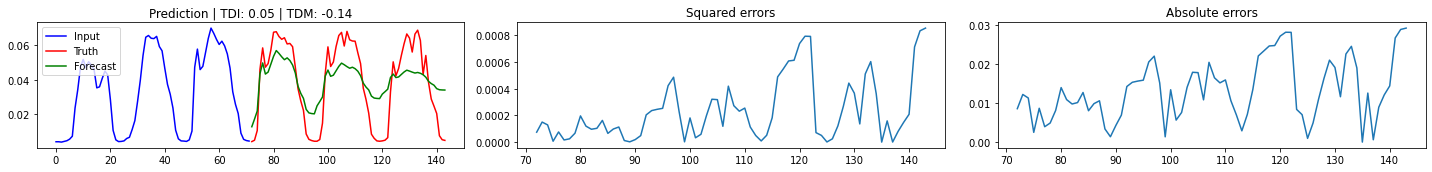

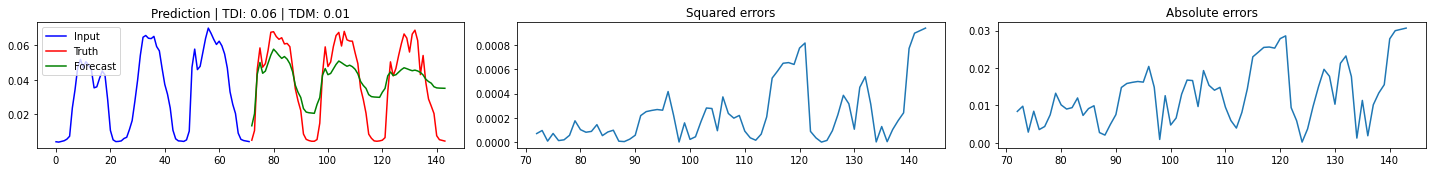

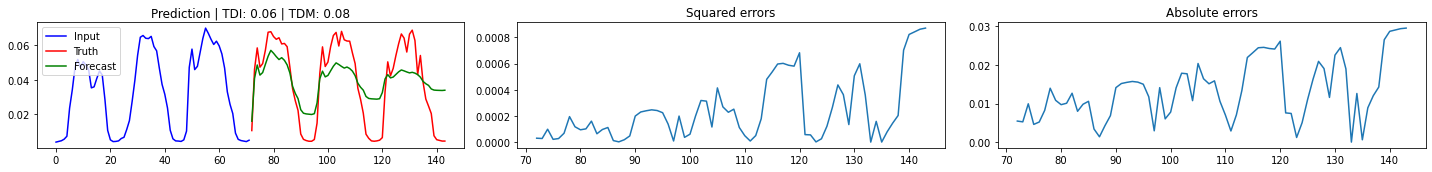

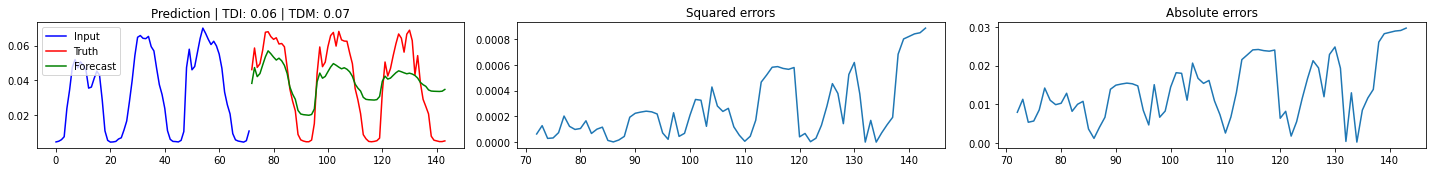

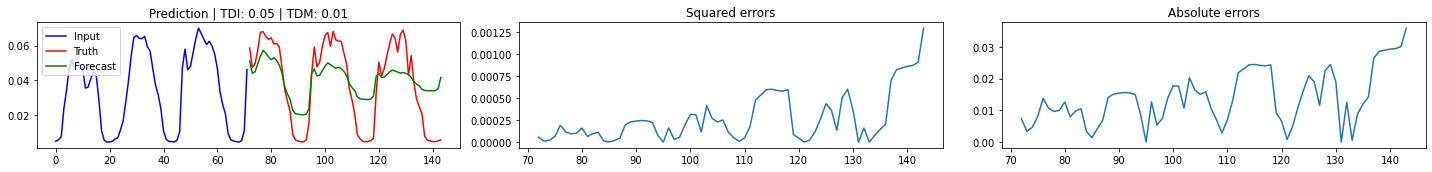

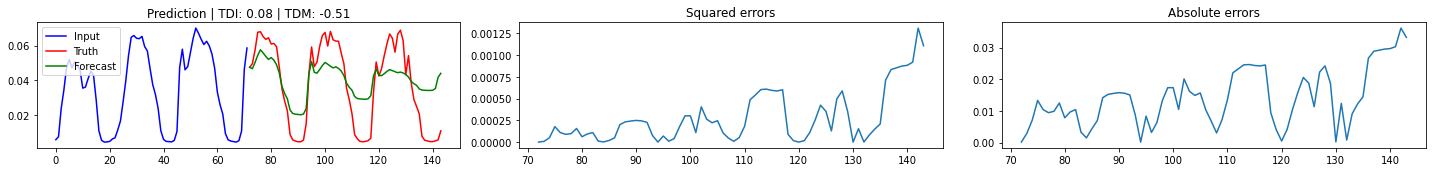

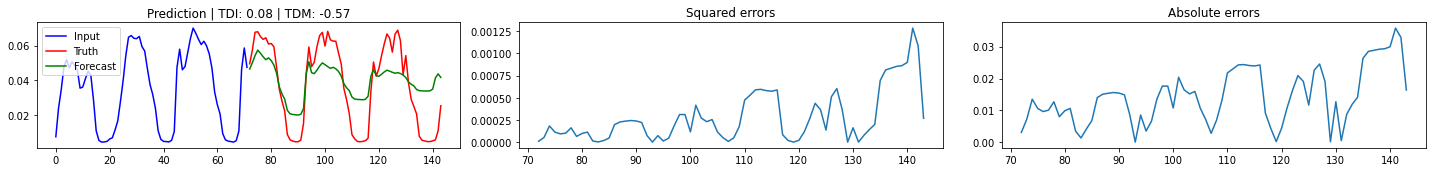

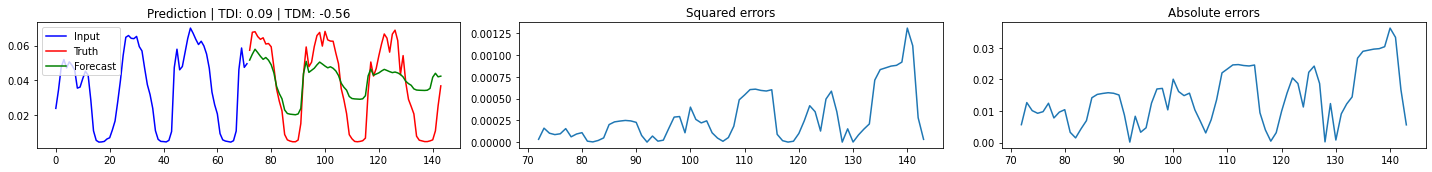

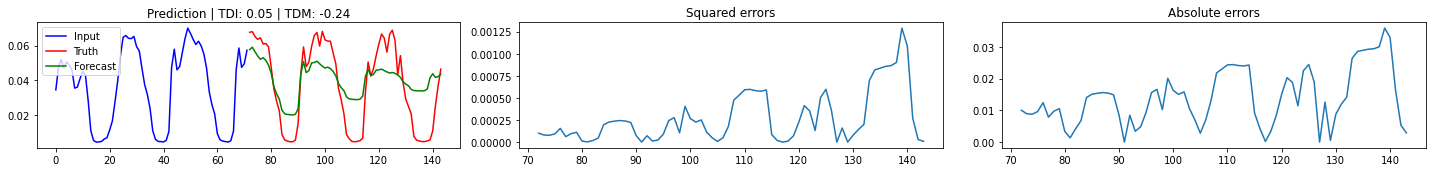

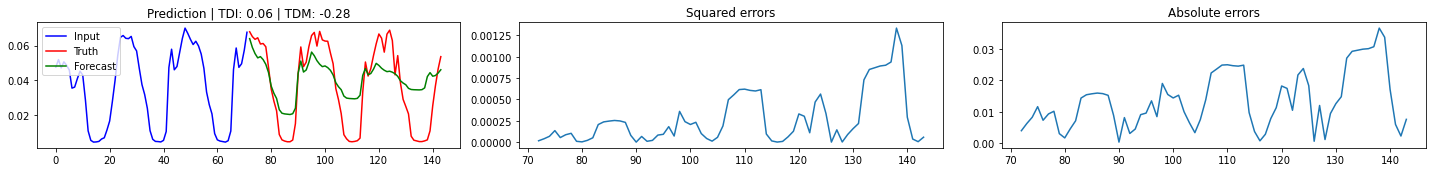

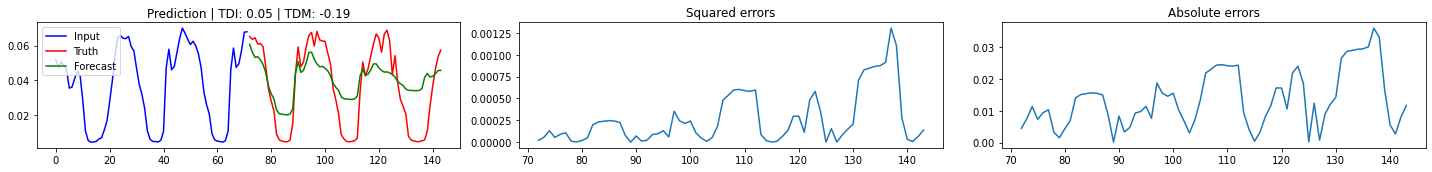

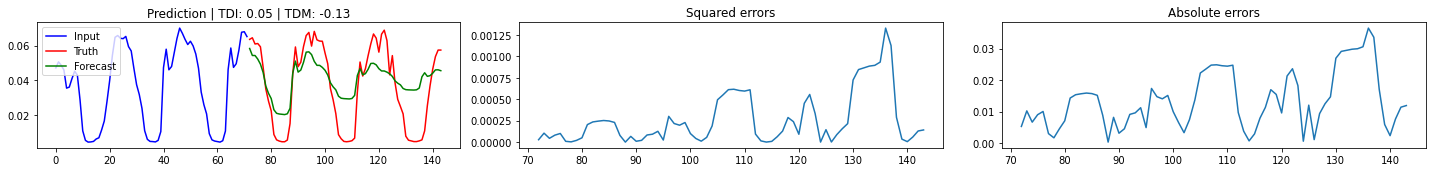

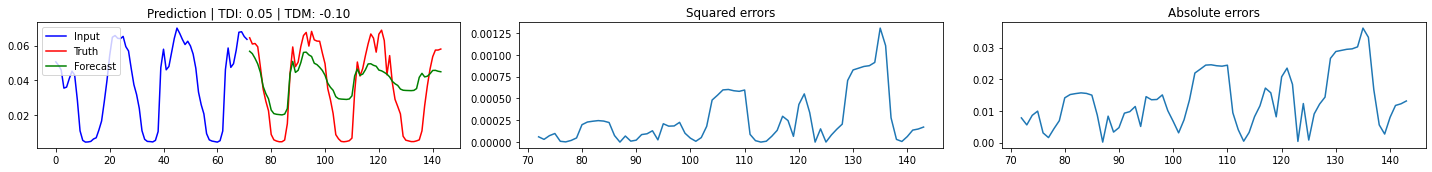

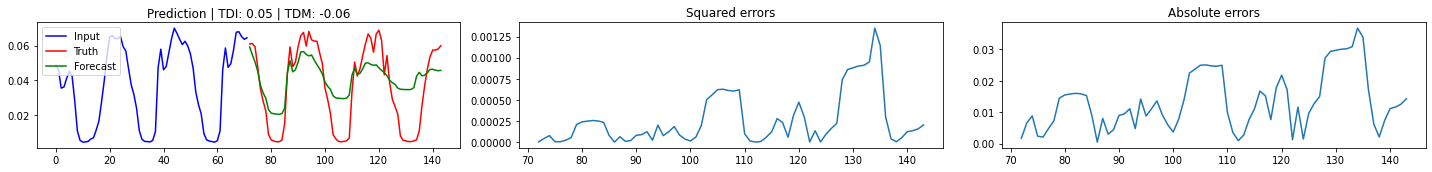

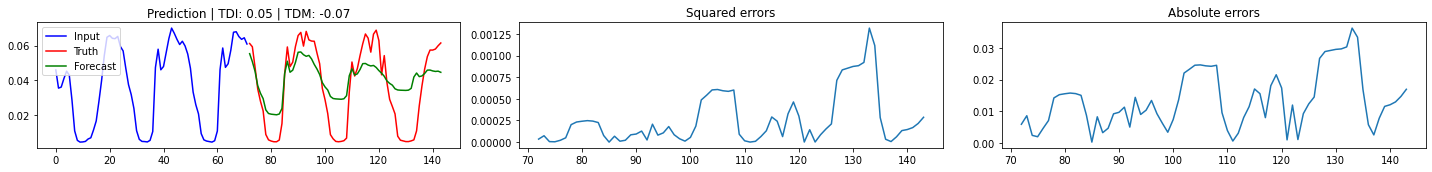

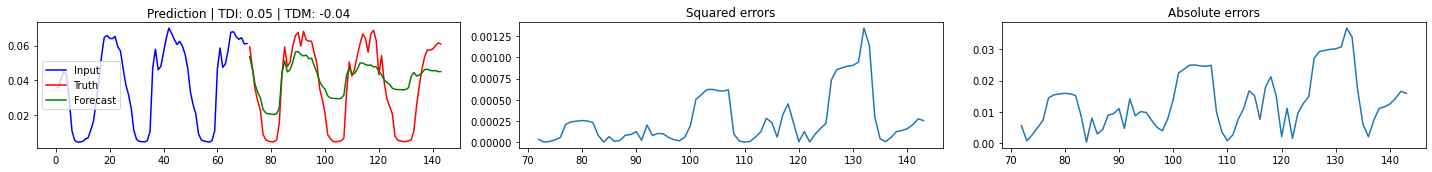

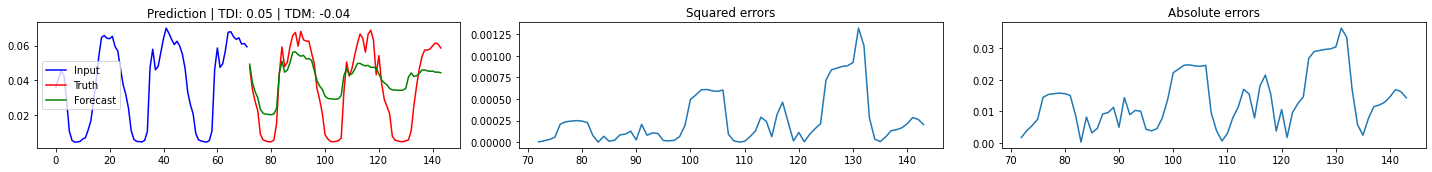

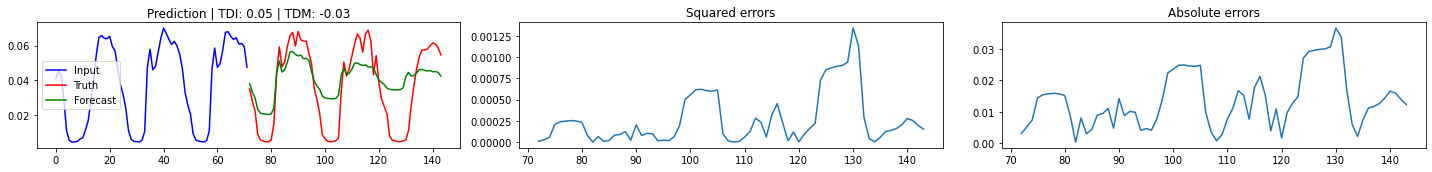

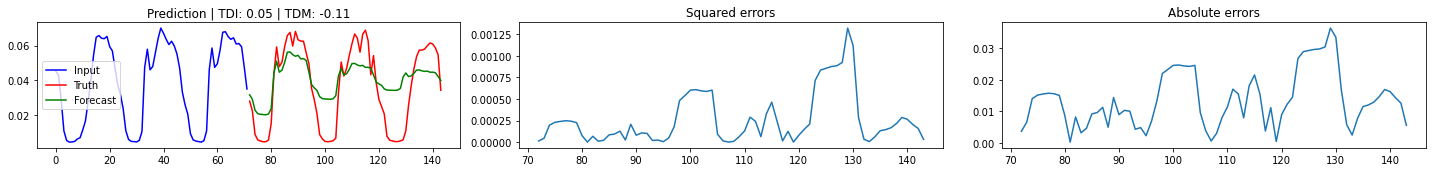

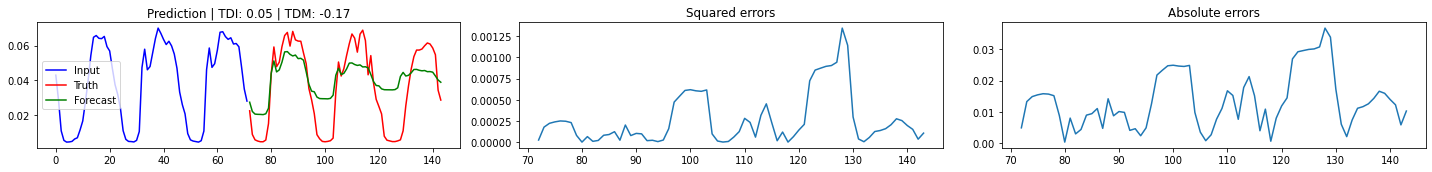

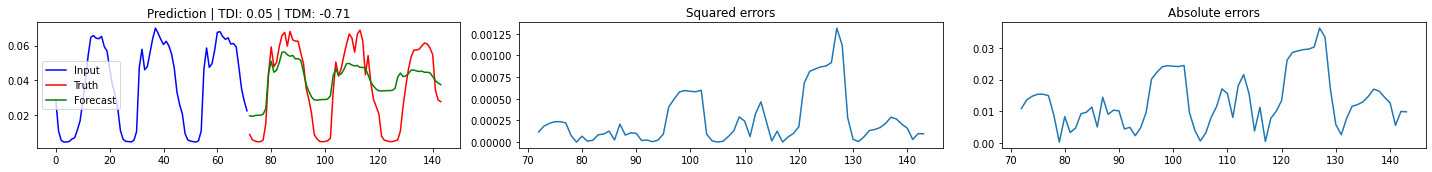

In [21]:
if True:
    results[-1].plot_forecasts(n=31, shuffle=False)

In [ ]:

# results = run_models_on_dataset2(archive='', ds_name='Traffic', in_size=24*3, out_size=24*3, arima_window=200, seasonal=True, m=24, test_frac=0.025)

# ARIMA on ECG5000

In [ ]:
# Parameters
n = 10
window = 56
horizon = 84

# Load data
df = pd.read_csv("./data/ECG5000/ECG5000_TRAIN.tsv", delimiter="\t", header=None).drop(0, axis=1).transpose()
df = df.diff().dropna()

for i in range(0, n):
    series = df[i].values
    train, test = train_test_split(series, train_size=window - 1)  # First row was removed by diff()
    
    with StepwiseContext(max_dur=15):
        model = pm.auto_arima(train, stepwise=True, suppress_warnings=True, trace=False, max_p=3, max_q=3, maxiter=35)
        
    forecast = model.predict(n_periods=test.shape[0])  # Predict N steps into the future
    
    plot_result(train, test, forecast, model)
    print("(TDI, TDM): ", calc_tdi_tdm(test, forecast))

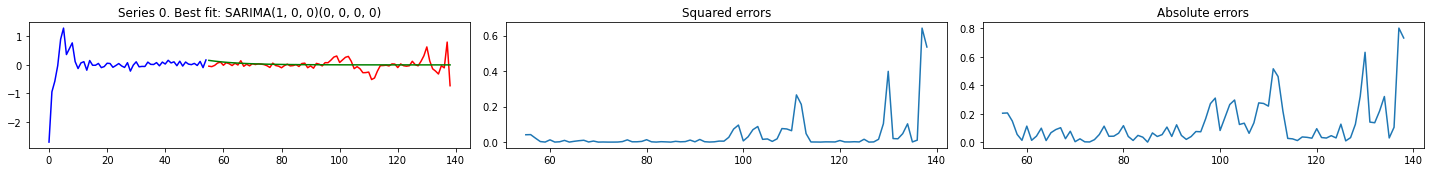

(TDI, TDM):  (0.1760204081632653, -0.4025764895330113)


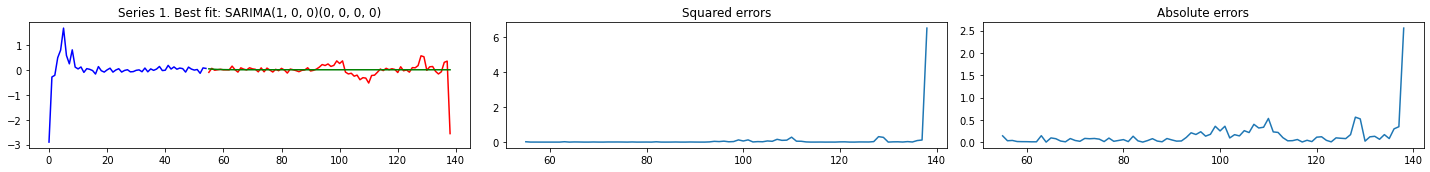

(TDI, TDM):  (0.5038265306122449, -1.0)


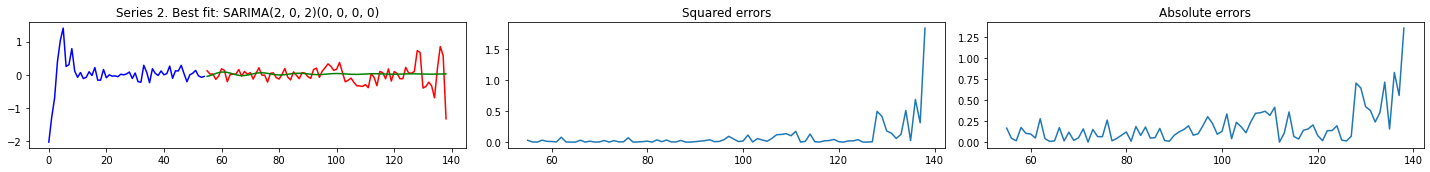

(TDI, TDM):  (0.5136054421768708, -1.0)


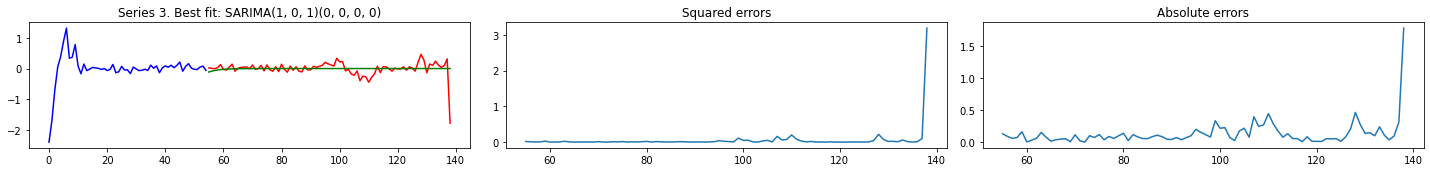

(TDI, TDM):  (0.40235260770975056, -0.9661852765058119)


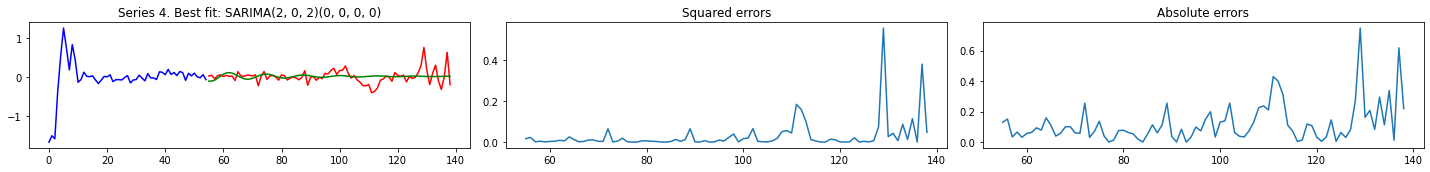

(TDI, TDM):  (0.7203798185941044, -0.9976391894550463)


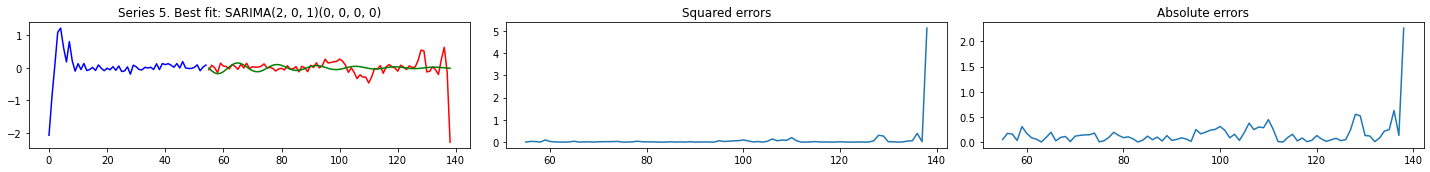

(TDI, TDM):  (0.5817743764172336, -0.9887941534713763)


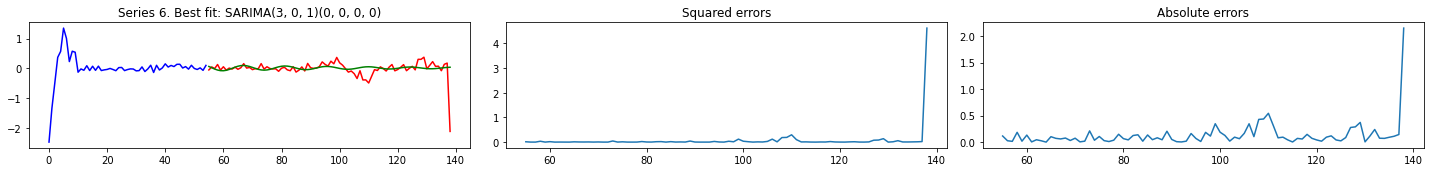

(TDI, TDM):  (0.43367346938775514, -0.9607843137254902)


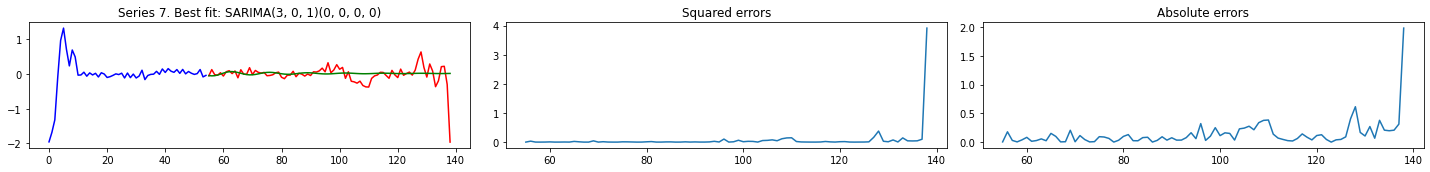

(TDI, TDM):  (0.48072562358276644, -0.9799528301886793)


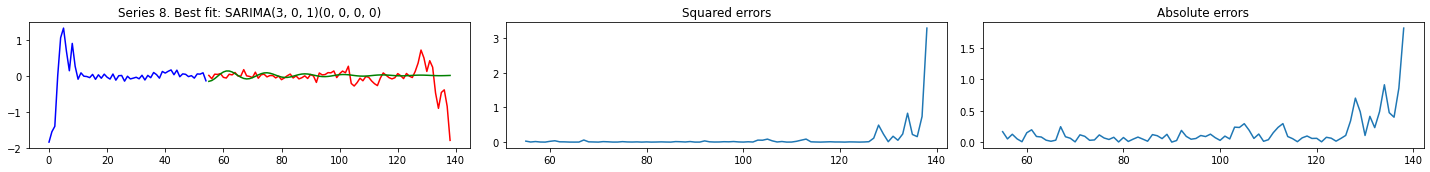

(TDI, TDM):  (0.4785997732426304, -0.9905241338466094)


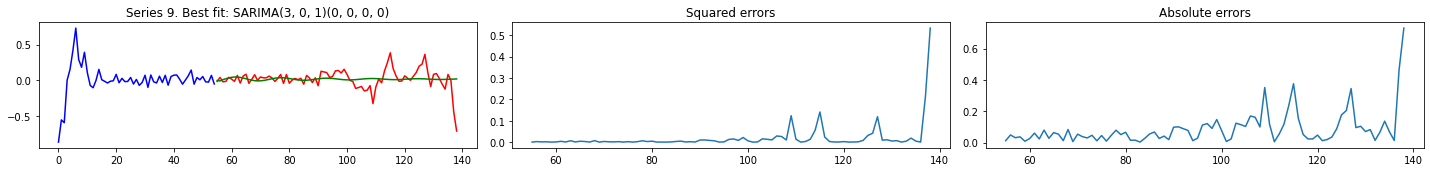

(TDI, TDM):  (0.6258503401360545, -1.0)


In [11]:
# Parameters
n = 10
window = 56
horizon = 84

# Load data
df = pd.read_csv("./data/ECG5000/ECG5000_TRAIN.tsv", delimiter="\t", header=None).drop(0, axis=1).transpose()
df = df.diff().dropna()

for i in range(0, n):
    series = df[i].values
    train, test = train_test_split(series, train_size=window - 1)  # First row was removed by diff()
    
    with StepwiseContext(max_dur=15):
        model = pm.auto_arima(train, stepwise=True, suppress_warnings=True, trace=False, max_p=3, max_q=3, maxiter=35)
        
    forecast = model.predict(n_periods=test.shape[0])  # Predict N steps into the future
    
    plot_result(train, test, forecast, model)
    print("(TDI, TDM): ", calc_tdi_tdm(test, forecast))

# ARIMA on Traffic

C:\Users\eivistr\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (82.561 > 10.000)
  warnings.warn('early termination of stepwise search due to '


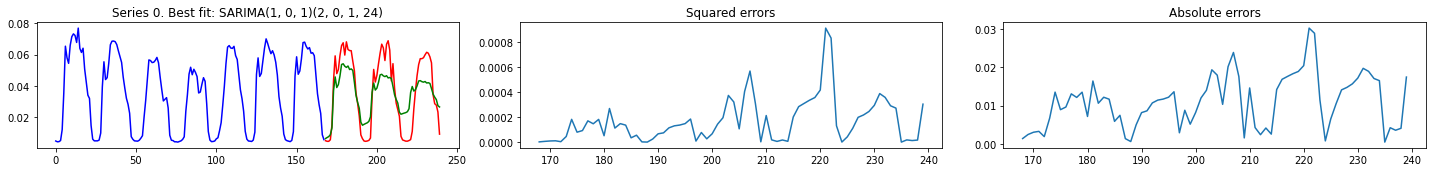

(TDI, TDM):  (0.04822530864197531, -0.504)


C:\Users\eivistr\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (21.711 > 10.000)
  warnings.warn('early termination of stepwise search due to '


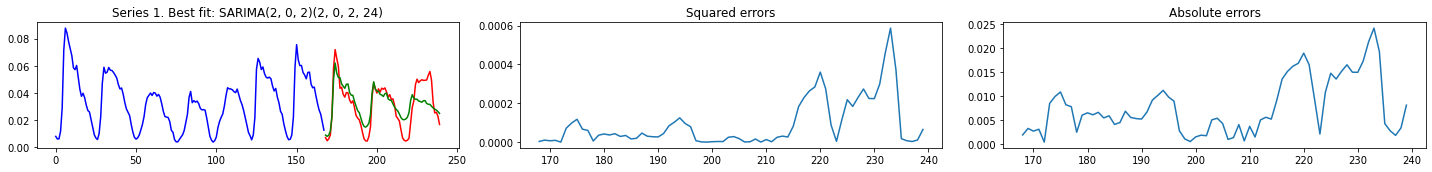

(TDI, TDM):  (0.07253086419753085, -0.5372340425531915)


C:\Users\eivistr\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (11.928 > 10.000)
  warnings.warn('early termination of stepwise search due to '


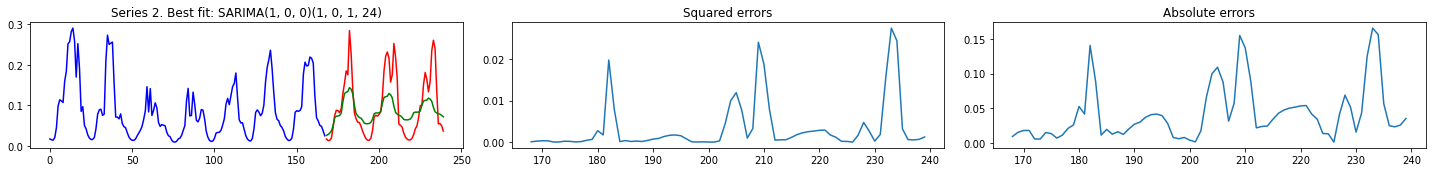

(TDI, TDM):  (0.04822530864197531, -0.128)


C:\Users\eivistr\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (53.914 > 10.000)
  warnings.warn('early termination of stepwise search due to '


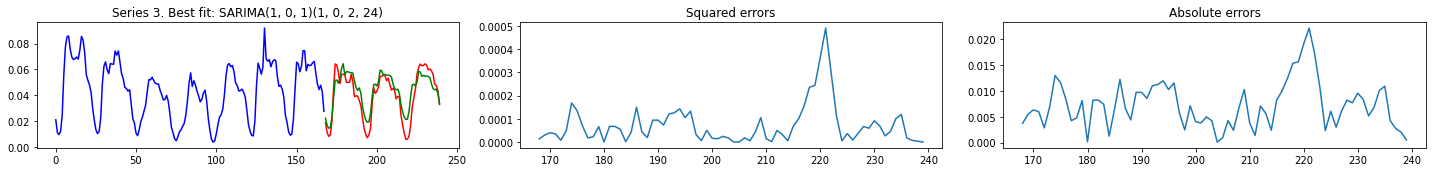

(TDI, TDM):  (0.05999228395061728, 0.12540192926045024)


C:\Users\eivistr\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (46.460 > 10.000)
  warnings.warn('early termination of stepwise search due to '


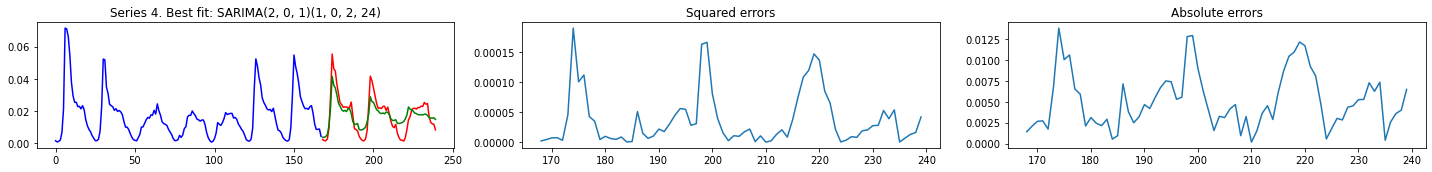

(TDI, TDM):  (0.07600308641975308, -0.7563451776649746)


C:\Users\eivistr\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (11.345 > 10.000)
  warnings.warn('early termination of stepwise search due to '


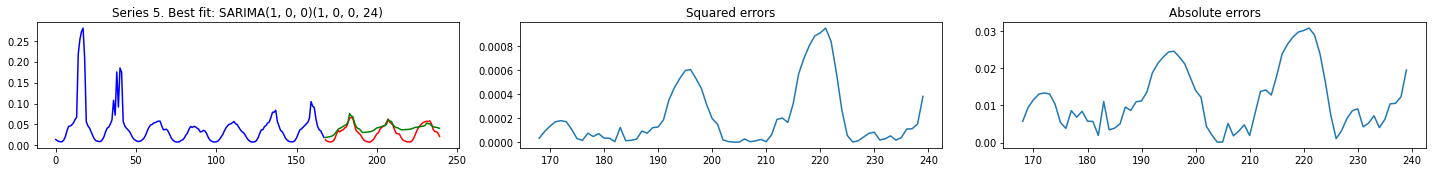

(TDI, TDM):  (0.06655092592592592, -0.5130434782608695)


C:\Users\eivistr\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (13.506 > 10.000)
  warnings.warn('early termination of stepwise search due to '


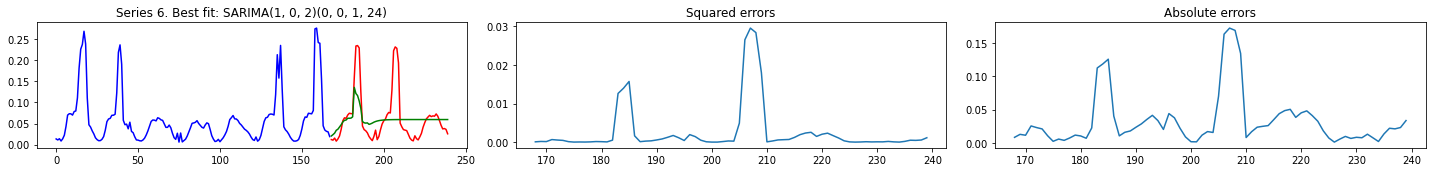

(TDI, TDM):  (0.2891589506172839, -0.9693128752501667)


C:\Users\eivistr\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (44.646 > 10.000)
  warnings.warn('early termination of stepwise search due to '


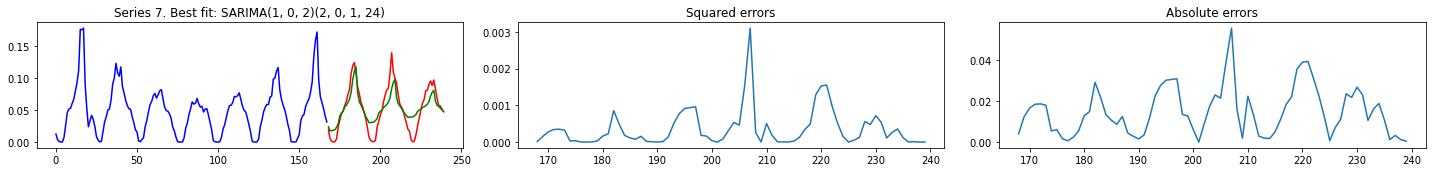

(TDI, TDM):  (0.046875, -0.12757201646090532)


C:\Users\eivistr\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (38.728 > 10.000)
  warnings.warn('early termination of stepwise search due to '


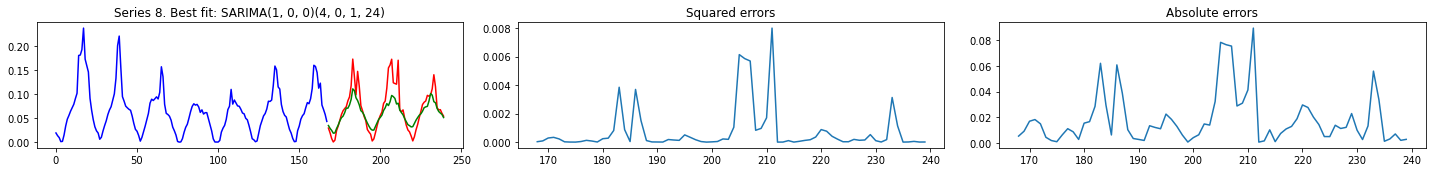

(TDI, TDM):  (0.03414351851851852, 0.02824858757062154)


C:\Users\eivistr\Anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (21.424 > 10.000)
  warnings.warn('early termination of stepwise search due to '


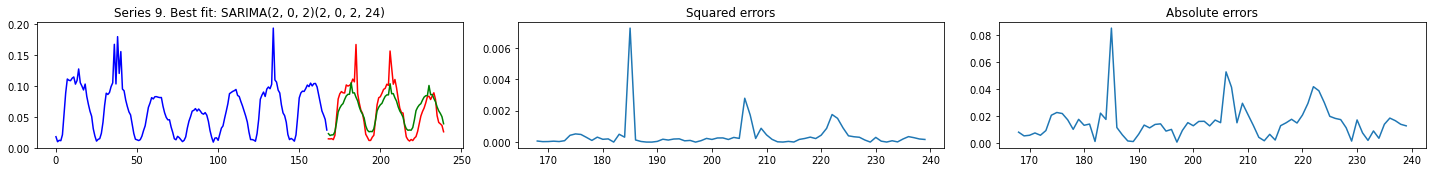

(TDI, TDM):  (0.05362654320987654, -0.15827338129496404)


In [21]:
# Parameters
n = 10
window = 24*7
horizon = 24*3

df = pd.read_csv("./data/mvdata/traffic.txt", usecols=range(0, n), header=None)

for i in range(0, n):
    series = df[i].values[-window-horizon:]
    train, test = train_test_split(series, train_size=window)
    
    with StepwiseContext(max_dur=10):
        model = pm.auto_arima(train, seasonal=True, m=24, suppress_warnings=True, trace=False, error_action='ignore', 
                              stepwise=True, max_p=3, max_q=3, max_P=4, max_Q=4, maxiter=30)
    forecast = model.predict(n_periods=test.shape[0])  # Predict N steps into the future
    
    plot_result(train, test, forecast, model)
    print("(TDI, TDM): ", calc_tdi_tdm(test, forecast))